# NLP10- Transformer : 번역기 성능 향상시키기
# 목차

> LMS 따라해보기 

1. 내부 모듈 구현하기
2. 모듈 조립하기
3. 모델 밖의 조력자들


> 프로젝트: 더 멋진 번역기 만들기

* STEP 1. 데이터 다운로드 (클라우드 유저용)
* STEP 2. 데이터 정제 및 토큰화
* STEP 3. 모델 설계
* STEP 4. 훈련하기



## 회고

# LMS 따라해보기 


올바른 Attention Map을 확인하기 위해 한국어를 지원하는 폰트로 변경

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)


'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

## 1.내부 모듈 구현

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.9.2


최초의 텍스트 입력 데이터: [ batch_size x length ] 의 형태를 가지고 있겠죠? 번역이 끝나고 난 최종 출력 데이터는 [ batch_size x length x vocab_size ]의 형태를

### 1)Positional Encoding

In [3]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table


### 2)Multi-Head Attention

 MultiHeadAttention 클래스를 정의

* `split_heads()`: Embedding된 입력을 Head 수로 분할
*` scaled_dot_product_attention()`: 분할된 입력으로부터 Attention 값을 출력
* `combine_heads()`: 연산이 종료되고 분할된 Head를 다시 하나로 결합

⚠️   `scaled_dot_product_attention()`: 마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 MultiHeadAttention 외부에 정의


In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

  
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights


### 3)Position-wise Feed-Forward Network(Dense)

d_ff = 2048, d_model = 512 

* [ batch x length x d_model ] 의 입력을 받아 
* w_1 이 2048차원으로 매핑하고 
* 활성함수 ReLU를 적용한 후, 
* 다시 w_2 를 통해 512차원으로 되돌리는 과정까지!

In [5]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out


## 2.내부 모듈 조립

### 1) Encoder Layer 구현

☀️  Layer Normalization의 위치
* pre-LN 방식 (official 구현) :  [Input] - `[Norm]` - [Module] - [Residual]
* post-LN 방식 (논문) : [Input] - [Module] - [Residual] - `[Norm]` (Module = MHA, FFN)

레이어가 많아질수록 `pre-LN 방식이 약간 더 좋은 성능`을 보였기에 논문 대신 Official 구현 권장


In [6]:
class EncoderLayer(tf.keras.layers.Layer):
  
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn



### 2) Decoder Layer 구현

⚠️ 참고: Decoder에서는 두 번의 Attention이 진행되니 반환되는 Attention도 두 개

In [7]:
# DecoderLayer 클래스를 작성하세요.

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns



In [9]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### 3) Transformer 조립

In [10]:

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns



## 3.모델 밖의 조력자들

### 1) Masking 

* `generate_padding_mask() ` Attention을 할 때에 <PAD> 토큰에도 Attention을 주는 것을 방지
 
일전에 Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행

한 배치의 데이터에서 <PAD> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크 생성

In [11]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask


첫 번째 마스크: 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다. 
두 번째와 세 번째의 Decoder가 연관된 마스크:  Causality Mask와 Padding Mask를 결합한 형태

 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 했던 것을 기억하시죠? 인과 관계를 가리는 것도 중요하지만 Decoder 역시 <PAD> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된답니다!

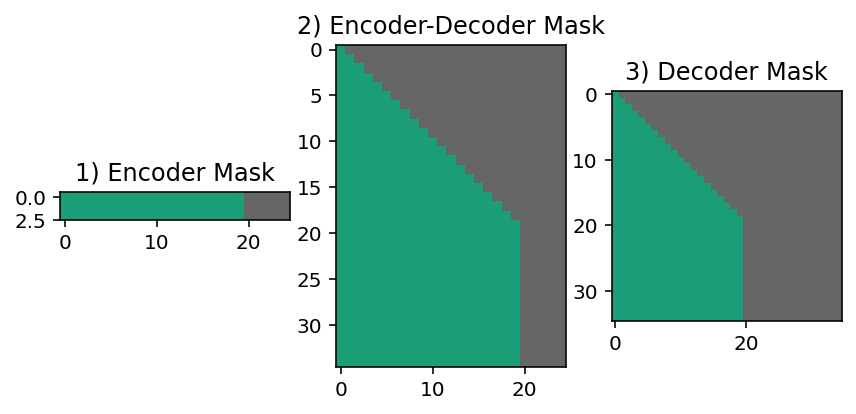

In [12]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### 2)Learning Rate

LearningRateSchedule 클래스를 상속받아 구현 : Tensorflow 상에서 잘 구동

Optimizer : 논문에 정의된 대로 Adam Optimize

In [13]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)



# 프로젝트: 더 멋진 번역기 만들기

In [14]:
import tensorflow
import numpy
import matplotlib

print(tensorflow.__version__)
print(numpy.__version__)
print(matplotlib.__version__)

2.9.2
1.21.6
3.2.2


## STEP 1. 데이터 다운로드 (클라우드 유저용)


`tf.keras.utils.get_file()` : 인터넷 상의 파일을 다운로드 받아 압축 해제. 


원하는 로컬 경로에 다운로드를 받고, 원하는 서브 디렉토리에 압축을 풀기 위해 사용.

In [15]:
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin='https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True)

8718893/8718893 [==============================] - 0s 0us/step


In [16]:
kor_path = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"
eng_path = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"

In [17]:
# print("Data Size:", len(raw_kor))
# print('\n')
# print("Example:")
# for sen in raw_kor[0:100:20]: print(">>", sen)

In [18]:
# print("Data Size:", len(raw_eng))
# print('\n')
# print("Example:")
# for sen in raw_eng[0:100:20]: print(">>", sen)

## STEP 2. 데이터 정제 및 토큰화


### 2-1.  중복데이터 제거 
* `중복을 허용하지 않는 set 데이터형` 을 활용해 중복된 데이터를 제거
* `데이터의 병렬 쌍`이 흐트러지지 않게 주의
* 중복을 제거한 데이터를 `cleaned_corpus 에 저장`


In [19]:

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: raw_kor = f.read().splitlines()
    with open(eng_path, "r") as f: raw_eng = f.read().splitlines()
    assert len(raw_kor) == len(raw_eng)

    cleaned_corpus = list(set(zip(raw_kor, raw_eng)))

    return cleaned_corpus


cleaned_corpus = clean_corpus(kor_path, eng_path)

In [20]:
type(cleaned_corpus)

list

In [21]:
cleaned_corpus[:5]

[('리차드 바우처 미 국무부 대변인은 기자 회견에서 이들 아시아 3국의 갈등이 핵 문제에는 영향을 주지 않았다고 밝혔다.',
  'Richard Boucher, spokesman of the U.S. State Department, said in a daily press briefing on April 13 that the dispute had not affected the approach to the nuclear issue.'),
 ('그러나 이 동영상에서 스피어스가 운전하는 차량이 파파라치의 발을 밟고 지나가는 장면은 나오지 않는다.',
  'Video on the Web site is titled "The Unfortunate Foot Incident," but doesn\'t show the tire of Spears\' car rolling over the cameraman\'s foot.'),
 ('Japan’s ambassador to Seoul has gone back to Tokyo.주한 일본 대사 본국으로 귀국',
  "Japan's ambassador has gone back to Tokyo to report on rising tensions here over the Japanese Shimane Prefecture's plans to designate Feb."),
 ('부상자 중에는 학생들도 포함돼있으며 이들은 버스정류장에서 폭발이 발생하면서 사고를 당했다.',
  'Among the injured were school students. A blast went off at a bus stop.'),
 ("천재 소녀의 '부활'", '... there has not been a lot of publicity.')]

### 2-2 정제 함수 정의 
> 정규표현식 조건
* 모든 입력을 소문자로 변환
* 알파벳, 문장부호, 한글만 남기고 모두 제거
* 문장부호 양옆에 공백을 추가
* 문장 앞뒤의 불필요한 공백을 제거

In [22]:

def preprocess_sentence(sentence, s_token=False, e_token=False):

    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)   #??
    sentence = re.sub(r'[" "]+', " ", sentence)         # 공백 여러개 공백하나로
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentence) # 대소문자, 기본 특수기호 외는 공백하나로

    sentence = sentence.strip()     # 양쪽 공백 제거 

    # if s_token:
    #     sentence = '<start> ' + sentence

    # if e_token:
    #     sentence += ' <end>'

    return sentence


### 2-3 토큰화
* 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리 
* 토큰화에는 Sentencepiece를 활용 
* generate_tokenizer() 함수를 정의
 >최종적으로 ko_tokenizer 과 en_tokenizer 출력

⚠️ en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 **타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함**할 수 있게 합니다.

* https://github.com/google/sentencepiece

> 토큰화 조건
* 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의 (기본: 20,000)
* 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환
* 특수 토큰의 인덱스 지정  
<PAD\> : 0 / <BOS\> : 1 / <EOS\> : 2 / <UNK\> : 3

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 9.7 MB/s 


In [25]:
import sentencepiece as spm

In [26]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    # [[YOUR CODE]]
    temp_file = f'/content/drive/MyDrive/Aiffel_data/NLP/[NLP-10]/temp_{lang}_txt.txt'

    # vocab_size = 8000

    with open(temp_file, 'w') as f:
       for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
           f.write(str(row) + '\n')

    spm.SentencePieceTrainer.Train(
       '--input={} --vocab_size={} --model_prefix=spm_{}\
        --pad_id={} --bos_id={} --eos_id={} --unk_id={}'.format(temp_file, vocab_size, lang , pad_id, bos_id, eos_id, unk_id))

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('spm_{}.model'.format(lang))

    return tokenizer
    

`preprocess_sentence()` 전처리 함수를 이용해 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리 

In [27]:
kor_corpus = []
eng_corpus = []

for kor, eng in cleaned_corpus:
    # tmp_kor = preprocess_sentence(kor)
    # tmp_eng = preprocess_sentence(eng, s_token = True, e_token = True)

    # kor_corpus.append(tmp_kor)
    # eng_corpus.append(tmp_eng)

    kor_corpus.append(preprocess_sentence(kor))
    eng_corpus.append(preprocess_sentence(eng, s_token = True, e_token = True))
    
print(len(kor_corpus))
print(len(eng_corpus))


78968
78968


In [28]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

kor_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
eng_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
eng_tokenizer.set_encode_extra_options("bos:eos")

True

### 2-4 길이 제한


>토큰길이 제한
* 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별
* src_corpus 와 tgt_corpus 를 각각 구축
* 텐서 enc_train 과 dec_train 으로 변환 

(❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)


In [29]:
# from tqdm.notebook import tqdm    # Process 과정을 보기 위해

# src_corpus = []
# tgt_corpus = []

# assert len(kor_corpus) == len(eng_corpus)

# # 토큰의 길이가 50 이하인 문장만 남깁니다. 
# for idx in tqdm(range(len(kor_corpus))):
#     if len(idx) <= 50:
#         src_corpus.append(idx)

# for idx in tqdm(range(len(eng_corpus))):
#     if len(idx) <= 50:
#         tgt_corpus.append(idx)
    

# # 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
# enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
# dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

EncodeAsPieces()

In [30]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위함

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    src = kor_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = eng_tokenizer.EncodeAsIds(eng_corpus[idx])

    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)


  0%|          | 0/78968 [00:00<?, ?it/s]

In [31]:
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

## STEP 3. 모델 설계

### 1) 모듈 구현

3-1 Positional Encoding 

In [32]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table


3-2 Multi-Head Attention

In [33]:
class MultiHeadAttention(tf.keras.layers.Layer):

  
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights


3-3 Position-wise Feed-Forward Network(Dense)

In [34]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out


### 2) 모듈 조립

3-1) Encoder Layer 구현

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
  
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn



Decoder Layer 구현

In [36]:
# DecoderLayer 클래스를 작성하세요.

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

Encoder

In [37]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns



Decoder

In [38]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


Trnasformer 조립

In [39]:

class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns



## STEP 4. 훈련하기

### 4-1) Transformer 선언 (with 2 Layer)

In [40]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared=True)

### 4-2)  Learning Rate Scheduler

In [41]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)


In [42]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

### 4-3) Loss 함수 

In [43]:
# Loss Function 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


### 4-4)Train step

In [44]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [45]:
# @tf.function
# def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
#     bsz = src.shape[0]
#     loss = 0

#     with tf.GradientTape() as tape:
#         enc_out = encoder(src)
#         h_dec = enc_out[:, -1]
        
#         dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

#         for t in range(1, tgt.shape[1]):
#             pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

#             loss += loss_function(tgt[:, t], pred)
#             dec_src = tf.expand_dims(tgt[:, t], 1)
        
#     batch_loss = (loss / int(tgt.shape[1]))

#     variables = encoder.trainable_variables + decoder.trainable_variables
#     gradients = tape.gradient(loss, variables)
#     optimizer.apply_gradients(zip(gradients, variables))
    
#     return batch_loss

## STEP 5. 시각화

In [46]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [47]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [48]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)
        

In [49]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 40

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, kor_tokenizer, eng_tokenizer)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s office is a white house .
Input: 시민들은 도시 속에 산다.
Predicted translation: the second time , the most of the storm .
Input: 커피는 필요 없다.
Predicted translation: it is not just .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the blast was killed by the dead .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first black .
Input: 시민들은 도시 속에 산다.
Predicted translation: the attackers have been killed .
Input: 커피는 필요 없다.
Predicted translation: coffee is not going to be coffee or not .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban areas .
Input: 커피는 필요 없다.
Predicted translation: coffee is no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president elect is the second president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is small .
Input: 커피는 필요 없다.
Predicted translation: coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven people died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first person .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are inner cities .
Input: 커피는 필요 없다.
Predicted translation: it needs to be on the issue .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first african president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are urbanly in one .
Input: 커피는 필요 없다.
Predicted translation: coffee is cabinetd .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died in seven deaths .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens in cities o depends on the city .
Input: 커피는 필요 없다.
Predicted translation: it s not just what .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven u . n . ministry confirmed dead .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens reviv their neighborhoods to o2 .
Input: 커피는 필요 없다.
Predicted translation: sea is not required to be present at the coffee house .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figure workers have died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re going to drive up .
Input: 커피는 필요 없다.
Predicted translation: it needs to take a bold response from the coffee industry .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a seven member of the fatality in the province .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big sign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban c2 transit service is just a city .
Input: 커피는 필요 없다.
Predicted translation: seas need a coffee rocket and so long
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths have been reported .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens to urbanization .
Input: 커피는 필요 없다.
Predicted translation: the coffee coast needs to be laughd .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven killed seven people .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens to urban caught in the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is addressing your needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they struck in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is required to take a live in at the coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are among the dead .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big opportunity .
Input: 시민들은 도시 속에 산다.
Predicted translation: they urban plan to kill in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is not the presumptive nominee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figure bodies died have been wounded .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they get a urban plan .
Input: 커피는 필요 없다.
Predicted translation: coffee is required to take no . dollar .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: a seventh died among police .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is driving .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seventeen people died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big position for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a taken from the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figure confirmed dead in the city .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: theyother cities in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is relative
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died of fires , the ministry confirmed dead .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: they pick up the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven dispatch fatal , in seven spanish .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the presidential race .
Input: 시민들은 도시 속에 산다.
Predicted translation: they city to the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figures have died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a medical thing .
Input: 시민들은 도시 속에 산다.
Predicted translation: they took the urban area .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figure confirmed dead .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is same .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and 55 wounded , the seven dead , a seven member of the associated press reported .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big cut .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is known as the singles city .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died of seven wounded .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big opportunity .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is actually starting .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figure confirmed dead by celebrities .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential term .
Input: 시민들은 도시 속에 산다.
Predicted translation: the other cities is true .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figure confirmed deadly .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: it is obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is known as the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven astronauts were among those killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: they gather in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: there is a obama horse with obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is up united .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven astronauts were among those killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a big reason .
Input: 시민들은 도시 속에 산다.
Predicted translation: they get a rural city to where .
Input: 커피는 필요 없다.
Predicted translation: sea ice is a coffee house .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: city eight neighborhoods later
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figures put the death toll at school .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: .
Input: 시민들은 도시 속에 산다.
Predicted translation: they get to cities in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is required to drink coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figures were reported .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is inknown to drive .
Input: 커피는 필요 없다.
Predicted translation: coffee is required to make sure coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figures have died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he s president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is same .
Input: 커피는 필요 없다.
Predicted translation: coffee is necessary , at coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the street is singled at the time .
Input: 커피는 필요 없다.
Predicted translation: coffee is necessary
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven iranian delegates died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is known .
Input: 커피는 필요 없다.
Predicted translation: coffee is giving coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven iraqis were killed .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a presidential term .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is same in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective , at least a00 solution
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven iranian delegates died .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they get caught in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective , at a coffee peak
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figures reported .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: he is a president of the obama administration .
Input: 시민들은 도시 속에 산다.
Predicted translation: they city simply cities in one city .
Input: 커피는 필요 없다.
Predicted translation: coffee is effective .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven figures were reported .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic presidential nominee .
Input: 시민들은 도시 속에 산다.
Predicted translation: they city cities in san jose
Input: 커피는 필요 없다.
Predicted translation: coffee is short fork information on them .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven iranian delegates died at seven barats .


  0%|          | 0/1114 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a tough thing .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is lured to the city .
Input: 커피는 필요 없다.
Predicted translation: it s not pro coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven iranian soldier died .


Input: 오바마는 대통령이다.
Predicted translation: obama is a tough thing .
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47560 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53685 missing from current font.
  font.set_

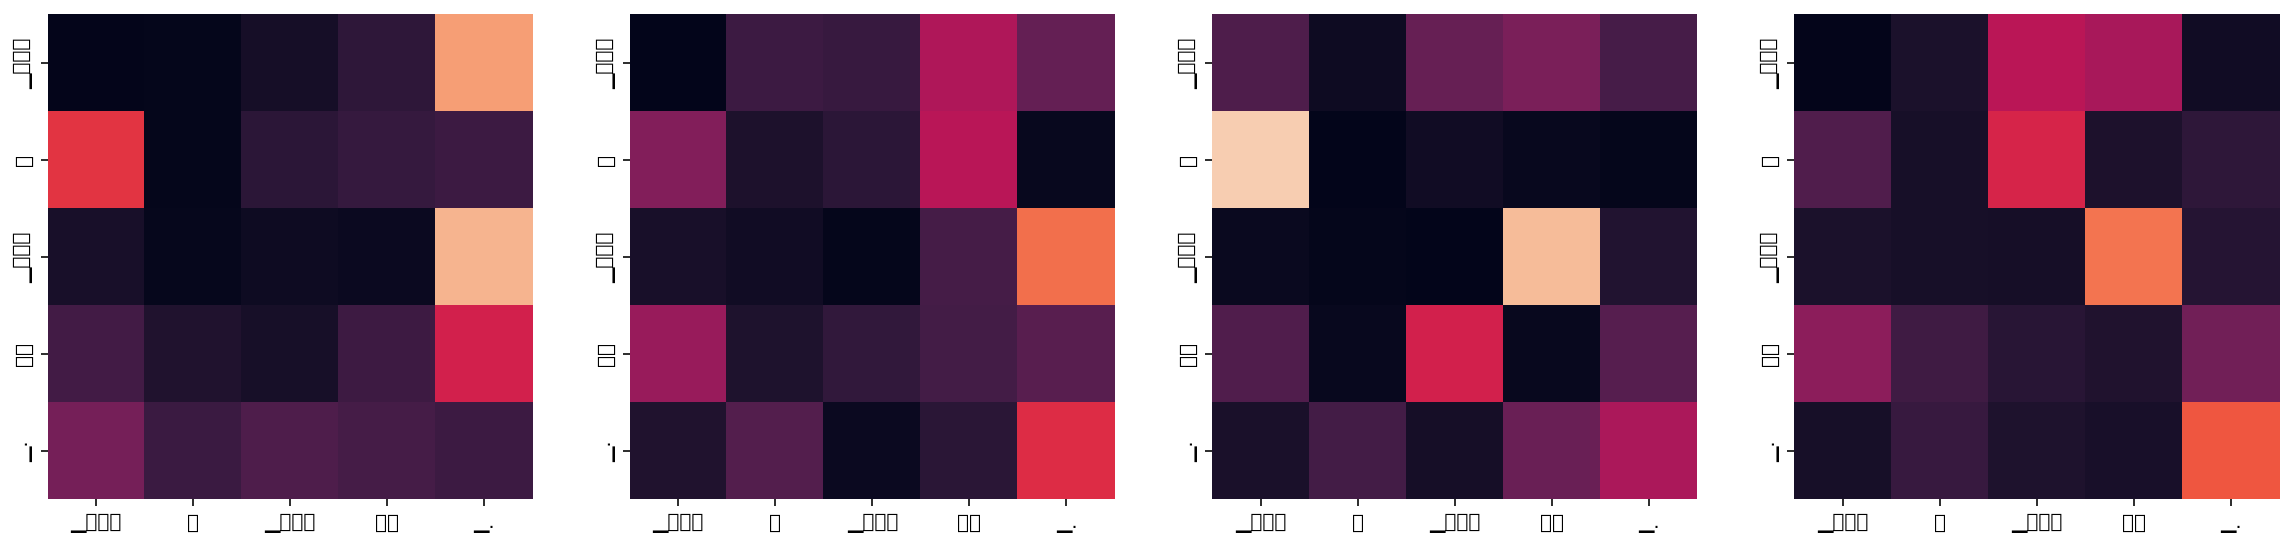

Encoder Layer 2


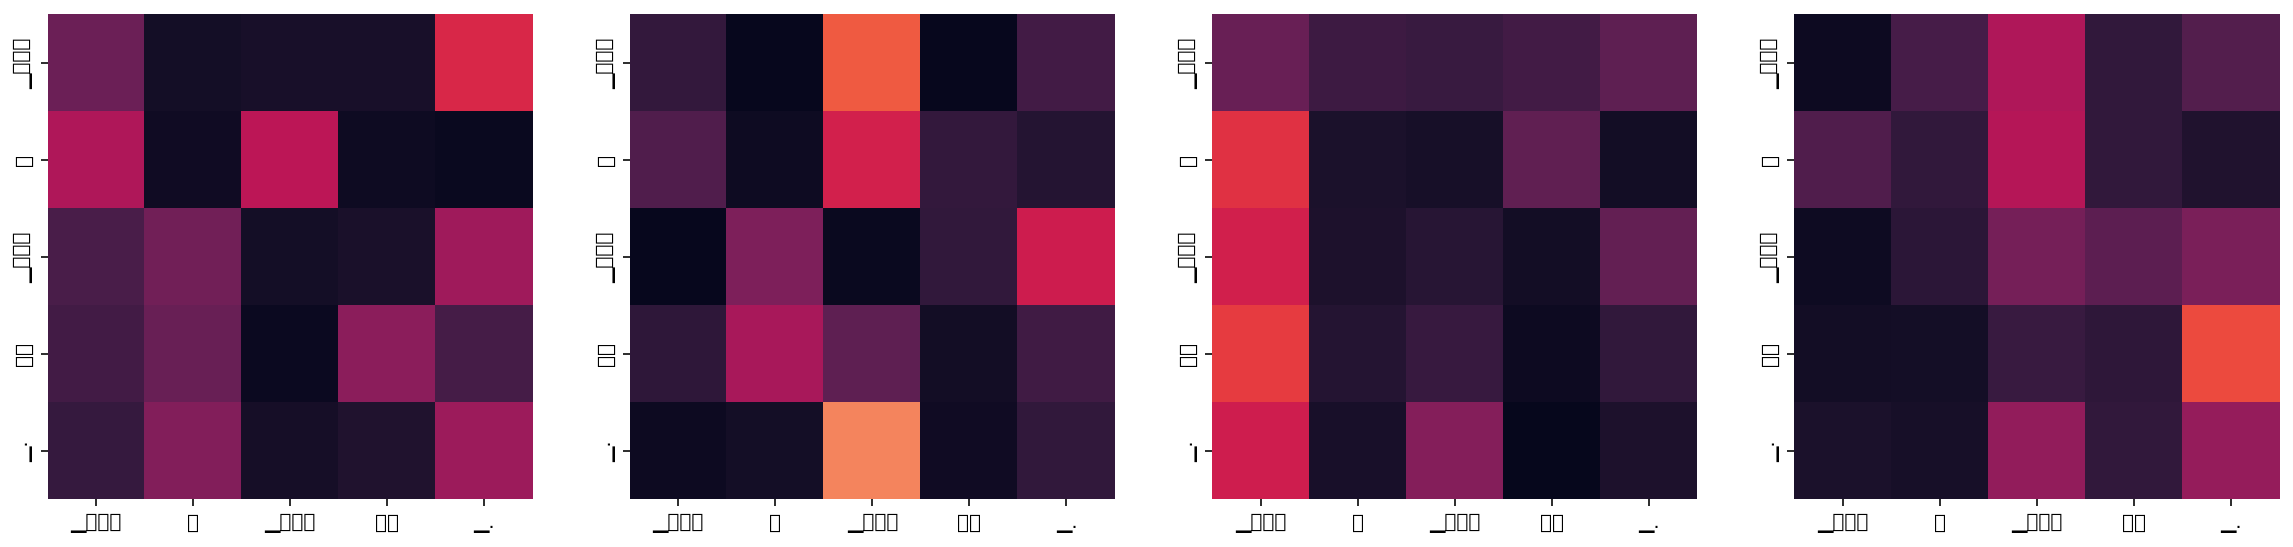

Decoder Self Layer 1


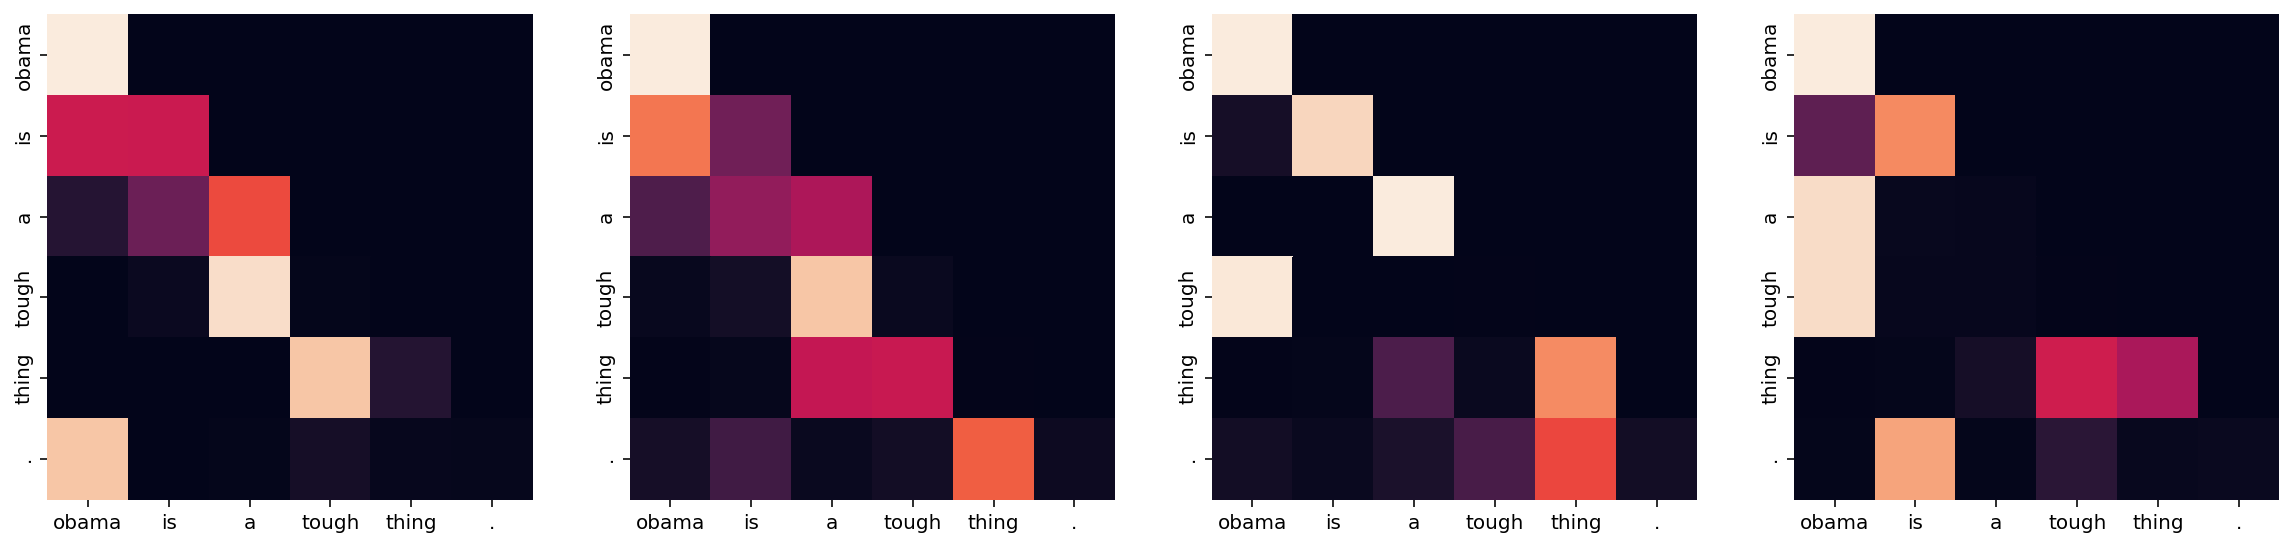

Decoder Src Layer 1


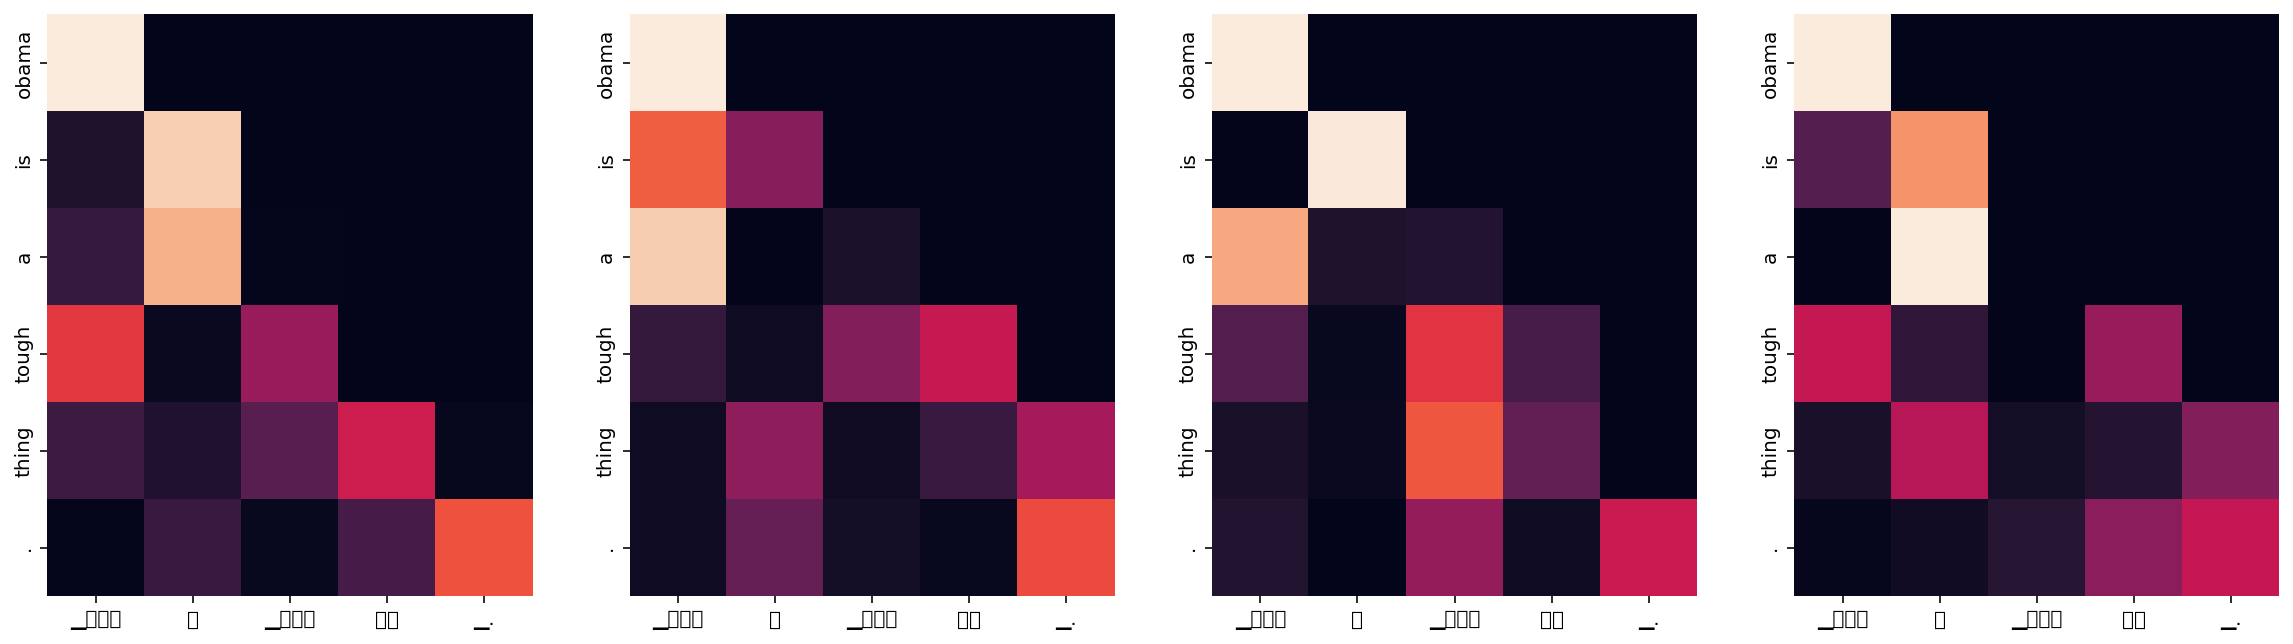

Decoder Self Layer 2


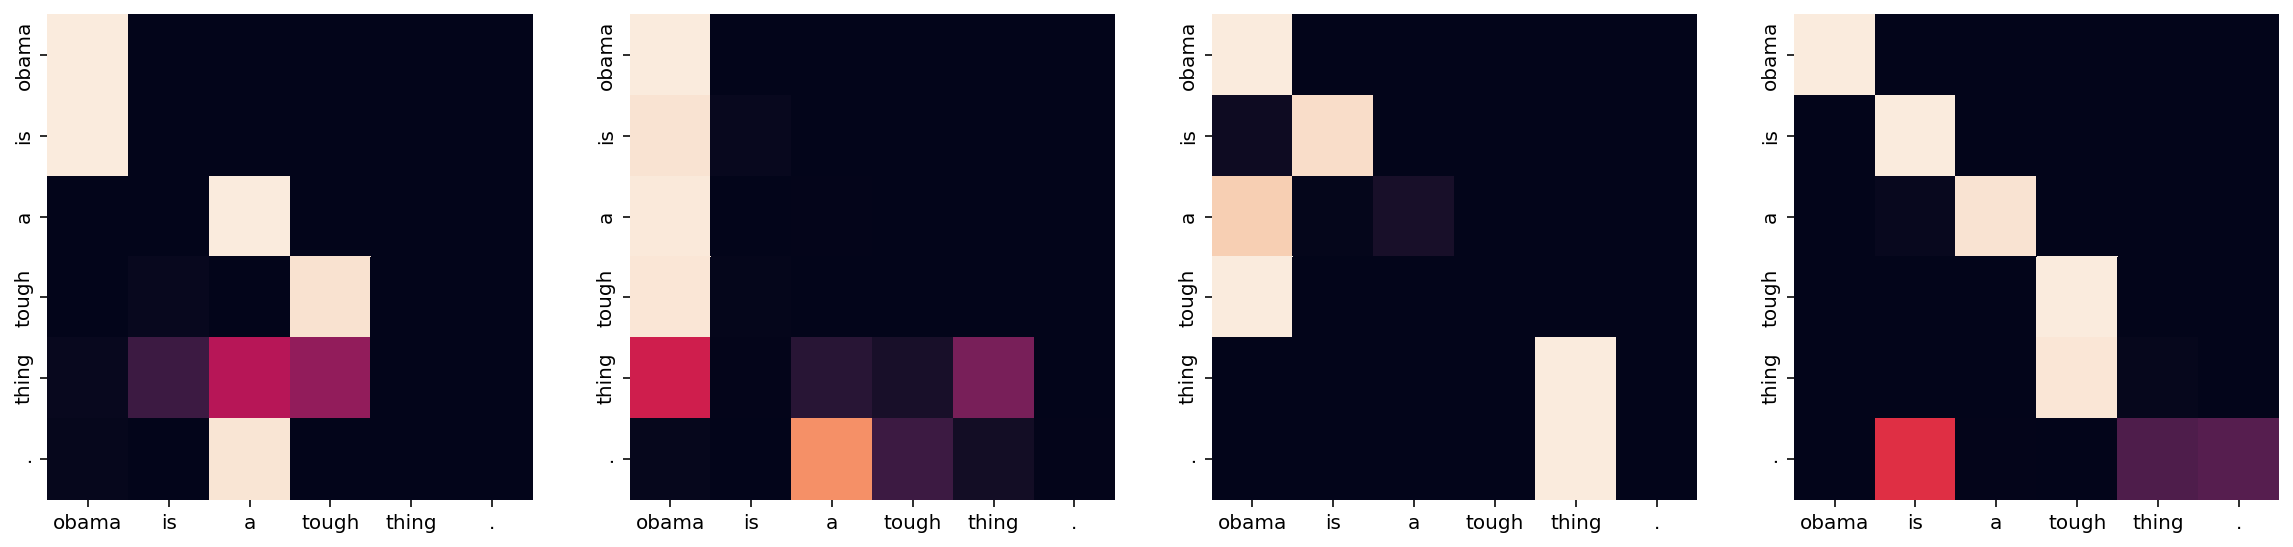

Decoder Src Layer 2


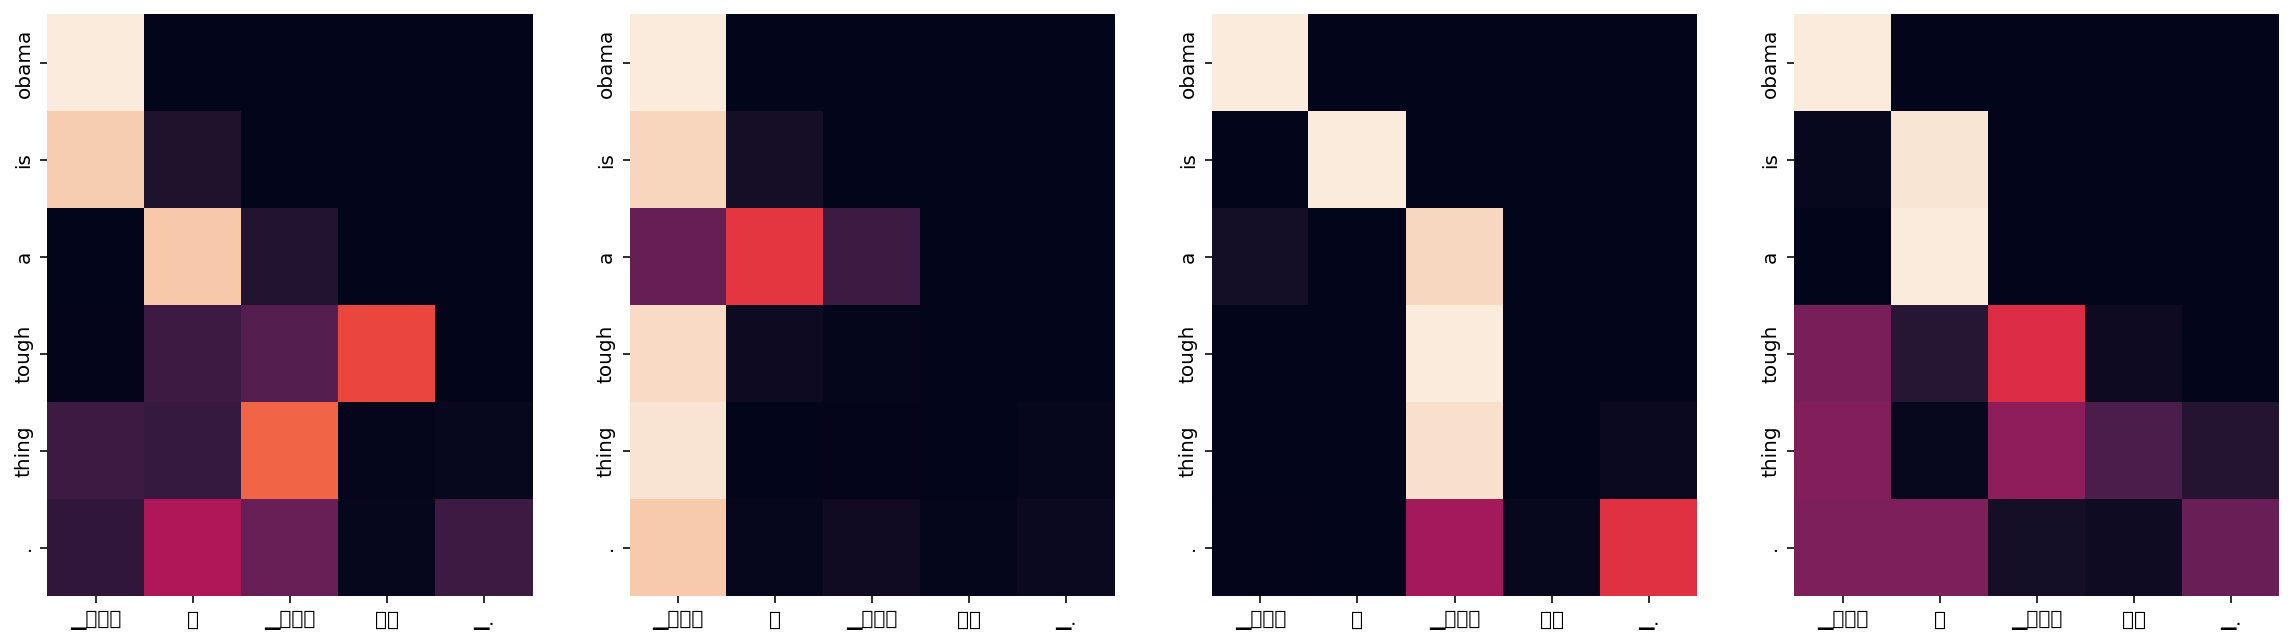

In [50]:
translate("오바마는 대통령이다.", transformer,kor_tokenizer, eng_tokenizer, True)

# 회고

### - 이번 프로젝트에서 **어려웠던 점**.


* Sentencepiece를 활용하여 generate_tokenizer() 함수 정의하기 
* loss 값에 비해 학습결과물이 좋지 않다.

>||Input|Output|
>|:---:|---|---|
>|1| 오바마는 대통령이다. |obama is a tough thing .|
>|2| 시민들은 도시 속에 산다.| the city is lured to the city .|
>|3|커피는 필요 없다.|it s not pro coffee .|
>|4| 일곱 명의 사망자가 발생했다.|seven iranian soldier died .|



### - 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
> 알아낸점
* tmp 파일 만들기 


> 모호한점
* attention map 해석



### - 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.



>#### **루브릭평가 지표**
>|번호|평가문항|상세기준|
>|:---:|---|---|
>|1| 번역기 모델 학습에 필요한 `텍스트 데이터 전처리`가 잘 이루어졌다. |데이터 정제, SentencePiece를 활용한 `토큰화 및 데이터셋 구축`의 과정이 지시대로 진행되었다.|
>|2| Transformer `번역기 모델이 정상적으로 구동`된다.| Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, `한-영 번역기능이 정상` 동작한다.|
>|3|테스트 결과 `의미가 통하는 수준의 번역문`이 생성되었다.|제시된 문장에 대한 `그럴듯한 영어 번역문`이 생성되며, `시각화된 Attention Map`으로 결과를 뒷받침한다.|



### - **자기 다짐**
* 어려운 코드 다시 한번 이해하며 읽기


### - **참고**
[Tokenizer](https://toramko.tistory.com/entry/nlp-sentencepiece-tokenizer-%EB%A1%9C-%EB%AC%B8%EC%9E%A5-%ED%86%A0%ED%81%B0%ED%99%94%ED%95%98%EA%B8%B0)

[Sentencepiece](https://wikidocs.net/86657)